# MAT3373: Methods of Machine Learning
## Long Homework 2

---

**Name:** Obay Alshaer  
**Student Number:** 300170489  
**Date:** November 30, 2025  
**Course Code:** MAT3373  
**Professor:** Aaron Smith

---

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
from scipy import stats
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

---
# Question 1: Empirical Study - Cross-Validation Method 1

**Objective:** Use 3-fold cross-validation to estimate the best value of $k$ for a KNN classifier on the MNIST dataset.

In [2]:
# Load MNIST dataset
mnist = pd.read_csv('mnist.csv')
print(f"MNIST Dataset Shape: {mnist.shape}")
mnist.head()

MNIST Dataset Shape: (10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Separate features and target
# Assuming first column is the label
X_mnist = mnist.iloc[:, 1:].values
y_mnist = mnist.iloc[:, 0].values

print(f"Features shape: {X_mnist.shape}")
print(f"Target shape: {y_mnist.shape}")
print(f"Unique classes: {np.unique(y_mnist)}")

Features shape: (10000, 784)
Target shape: (10000,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]


In [4]:
# 3-Fold Cross-Validation for KNN
k_values = range(1, 21)
cv_train_errors = []
cv_test_errors = []

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X_mnist):
        X_train_fold, X_test_fold = X_mnist[train_idx], X_mnist[test_idx]
        y_train_fold, y_test_fold = y_mnist[train_idx], y_mnist[test_idx]
        
        knn.fit(X_train_fold, y_train_fold)
        
        # Training error
        train_pred = knn.predict(X_train_fold)
        train_error = 1 - accuracy_score(y_train_fold, train_pred)
        fold_train_errors.append(train_error)
        
        # Test error
        test_pred = knn.predict(X_test_fold)
        test_error = 1 - accuracy_score(y_test_fold, test_pred)
        fold_test_errors.append(test_error)
    
    cv_train_errors.append(np.mean(fold_train_errors))
    cv_test_errors.append(np.mean(fold_test_errors))
    
    print(f"k={k}: Train Error={np.mean(fold_train_errors):.4f}, Test Error={np.mean(fold_test_errors):.4f}")

k=1: Train Error=0.0000, Test Error=0.0522
k=2: Train Error=0.0286, Test Error=0.0616
k=3: Train Error=0.0257, Test Error=0.0532
k=4: Train Error=0.0331, Test Error=0.0544
k=5: Train Error=0.0350, Test Error=0.0552
k=6: Train Error=0.0408, Test Error=0.0557
k=7: Train Error=0.0416, Test Error=0.0568
k=8: Train Error=0.0453, Test Error=0.0592
k=9: Train Error=0.0466, Test Error=0.0604
k=10: Train Error=0.0488, Test Error=0.0629
k=11: Train Error=0.0513, Test Error=0.0631
k=12: Train Error=0.0528, Test Error=0.0662
k=13: Train Error=0.0550, Test Error=0.0663
k=14: Train Error=0.0572, Test Error=0.0677
k=15: Train Error=0.0589, Test Error=0.0681
k=16: Train Error=0.0603, Test Error=0.0697
k=17: Train Error=0.0610, Test Error=0.0706
k=18: Train Error=0.0621, Test Error=0.0729
k=19: Train Error=0.0635, Test Error=0.0718
k=20: Train Error=0.0651, Test Error=0.0737


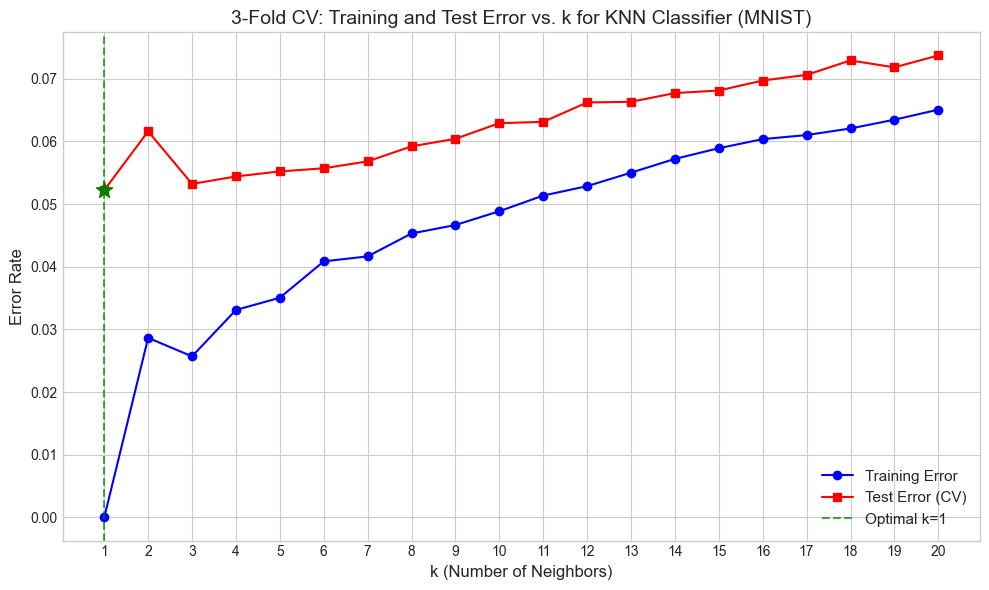


Optimal k: 1
Minimum CV Test Error: 0.0522


In [5]:
# Plot training and test error vs k
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_values, cv_train_errors, 'b-o', label='Training Error', markersize=6)
ax.plot(k_values, cv_test_errors, 'r-s', label='Test Error (CV)', markersize=6)

# Mark optimal k
optimal_k = k_values[np.argmin(cv_test_errors)]
min_test_error = min(cv_test_errors)
ax.axvline(x=optimal_k, color='green', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
ax.scatter([optimal_k], [min_test_error], color='green', s=150, zorder=5, marker='*')

ax.set_xlabel('k (Number of Neighbors)', fontsize=12)
ax.set_ylabel('Error Rate', fontsize=12)
ax.set_title('3-Fold CV: Training and Test Error vs. k for KNN Classifier (MNIST)', fontsize=14)
ax.legend(fontsize=11)
ax.set_xticks(k_values)
plt.tight_layout()
plt.show()

print(f"\nOptimal k: {optimal_k}")
print(f"Minimum CV Test Error: {min_test_error:.4f}")

**Conclusion for Q1:** The 3-fold cross-validation reveals the bias-variance tradeoff. Small $k$ values lead to overfitting (low training error, high test error), while large $k$ values lead to underfitting. The optimal $k$ balances these effects.

---
# Question 2: Empirical Study - Cross-Validation Method 2

**Objective:** Predict wine quality using multiple regression approaches on the red wine dataset.

In [6]:
# Load red wine dataset
wine = pd.read_csv('redwine.csv', sep=';')  # UCI wine datasets typically use semicolon separator
print(f"Wine Dataset Shape: {wine.shape}")
wine.head()

Wine Dataset Shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# Check for missing values and data info
print("\nDataset Info:")
print(wine.info())
print("\nDescriptive Statistics:")
wine.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

Descriptive Statistics:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Part 1: Train-Test Split

In [9]:
# Separate features and target
X_wine = wine.drop('quality', axis=1)
y_wine = wine['quality']

# Train-test split (80-20)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train_wine.shape[0]}")
print(f"Test set size: {X_test_wine.shape[0]}")

Training set size: 1279
Test set size: 320


## Part 2(a): Ordinary Least Squares

In [10]:
# Fit OLS model
ols_model = LinearRegression()
ols_model.fit(X_train_wine, y_train_wine)

# Predictions and test error
y_pred_ols = ols_model.predict(X_test_wine)
mse_ols = mean_squared_error(y_test_wine, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)

print("OLS Linear Regression Results:")
print(f"Test MSE: {mse_ols:.4f}")
print(f"Test RMSE: {rmse_ols:.4f}")
print(f"\nCoefficients:")
for name, coef in zip(X_wine.columns, ols_model.coef_):
    print(f"  {name}: {coef:.4f}")
print(f"  Intercept: {ols_model.intercept_:.4f}")

OLS Linear Regression Results:
Test MSE: 0.3900
Test RMSE: 0.6245

Coefficients:
  fixed acidity: 0.0231
  volatile acidity: -1.0013
  citric acid: -0.1408
  residual sugar: 0.0066
  chlorides: -1.8065
  free sulfur dioxide: 0.0056
  total sulfur dioxide: -0.0036
  density: -10.3516
  pH: -0.3937
  sulphates: 0.8412
  alcohol: 0.2819
  Intercept: 14.3551


## Part 2(b): Ridge Regression

In [11]:
# Ridge regression with cross-validation
alphas_ridge = np.logspace(-4, 4, 100)
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train_wine, y_train_wine)

# Best hyperparameter
best_lambda_ridge = ridge_cv.alpha_
print(f"Ridge Regression - Best λ (alpha): {best_lambda_ridge:.6f}")

# Predictions and test error
y_pred_ridge = ridge_cv.predict(X_test_wine)
mse_ridge = mean_squared_error(y_test_wine, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print(f"Test MSE: {mse_ridge:.4f}")
print(f"Test RMSE: {rmse_ridge:.4f}")
print(f"\nCoefficients:")
for name, coef in zip(X_wine.columns, ridge_cv.coef_):
    print(f"  {name}: {coef:.4f}")

Ridge Regression - Best λ (alpha): 0.521401
Test MSE: 0.3918
Test RMSE: 0.6260

Coefficients:
  fixed acidity: 0.0174
  volatile acidity: -1.0209
  citric acid: -0.1599
  residual sugar: 0.0013
  chlorides: -1.4523
  free sulfur dioxide: 0.0057
  total sulfur dioxide: -0.0036
  density: -0.0185
  pH: -0.4038
  sulphates: 0.7790
  alcohol: 0.2952


## Part 2(c): LASSO Regression

In [12]:
# LASSO regression with cross-validation
alphas_lasso = np.logspace(-4, 1, 100)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_wine, y_train_wine)

# Best hyperparameter
best_lambda_lasso = lasso_cv.alpha_
print(f"LASSO Regression - Best λ (alpha): {best_lambda_lasso:.6f}")

# Predictions and test error
y_pred_lasso = lasso_cv.predict(X_test_wine)
mse_lasso = mean_squared_error(y_test_wine, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

print(f"Test MSE: {mse_lasso:.4f}")
print(f"Test RMSE: {rmse_lasso:.4f}")
print(f"\nCoefficients:")
for name, coef in zip(X_wine.columns, lasso_cv.coef_):
    status = "(selected)" if coef != 0 else "(dropped)"
    print(f"  {name}: {coef:.4f} {status}")

n_selected = np.sum(lasso_cv.coef_ != 0)
print(f"\nNumber of selected features: {n_selected}/{len(X_wine.columns)}")

LASSO Regression - Best λ (alpha): 0.000254
Test MSE: 0.3914
Test RMSE: 0.6256

Coefficients:
  fixed acidity: 0.0146 (selected)
  volatile acidity: -1.0033 (selected)
  citric acid: -0.1252 (selected)
  residual sugar: 0.0014 (selected)
  chlorides: -1.6684 (selected)
  free sulfur dioxide: 0.0058 (selected)
  total sulfur dioxide: -0.0037 (selected)
  density: -0.0000 (dropped)
  pH: -0.4114 (selected)
  sulphates: 0.8024 (selected)
  alcohol: 0.2921 (selected)

Number of selected features: 10/11


## Part 2(d): Forward and Backward Stepwise Selection

In [13]:
# Forward stepwise selection
lr_forward = LinearRegression()
sfs_forward = SequentialFeatureSelector(
    lr_forward, n_features_to_select='auto', direction='forward', cv=5
)
sfs_forward.fit(X_train_wine, y_train_wine)

# Get selected features
forward_mask = sfs_forward.get_support()
forward_features = X_wine.columns[forward_mask].tolist()
print("Forward Stepwise Selection:")
print(f"Selected features: {forward_features}")

# Fit model with selected features
lr_forward_final = LinearRegression()
lr_forward_final.fit(X_train_wine[forward_features], y_train_wine)
y_pred_forward = lr_forward_final.predict(X_test_wine[forward_features])
mse_forward = mean_squared_error(y_test_wine, y_pred_forward)
rmse_forward = np.sqrt(mse_forward)
print(f"Test MSE: {mse_forward:.4f}")
print(f"Test RMSE: {rmse_forward:.4f}")

Forward Stepwise Selection:
Selected features: ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
Test MSE: 0.3948
Test RMSE: 0.6283


In [14]:
# Backward stepwise selection
lr_backward = LinearRegression()
sfs_backward = SequentialFeatureSelector(
    lr_backward, n_features_to_select='auto', direction='backward', cv=5
)
sfs_backward.fit(X_train_wine, y_train_wine)

# Get selected features
backward_mask = sfs_backward.get_support()
backward_features = X_wine.columns[backward_mask].tolist()
print("\nBackward Stepwise Selection:")
print(f"Selected features: {backward_features}")

# Fit model with selected features
lr_backward_final = LinearRegression()
lr_backward_final.fit(X_train_wine[backward_features], y_train_wine)
y_pred_backward = lr_backward_final.predict(X_test_wine[backward_features])
mse_backward = mean_squared_error(y_test_wine, y_pred_backward)
rmse_backward = np.sqrt(mse_backward)
print(f"Test MSE: {mse_backward:.4f}")
print(f"Test RMSE: {rmse_backward:.4f}")


Backward Stepwise Selection:
Selected features: ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
Test MSE: 0.3901
Test RMSE: 0.6246


## Part 3: Results Comparison


SUMMARY OF RESULTS
           Method  Test MSE  Test RMSE
              OLS  0.390025   0.624520
Backward Stepwise  0.390091   0.624573
            LASSO  0.391430   0.625643
            Ridge  0.391828   0.625962
 Forward Stepwise  0.394790   0.628323


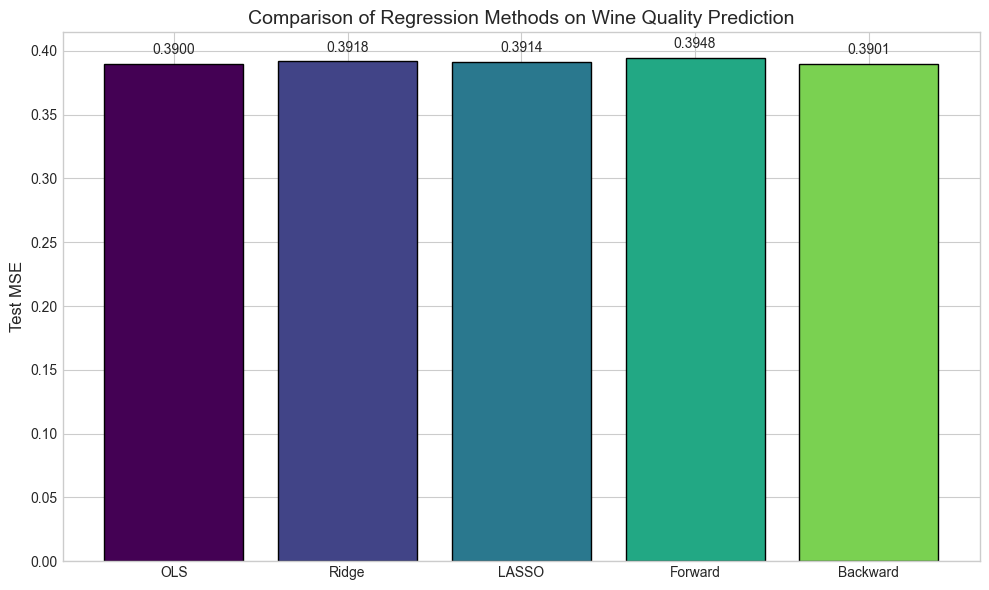

In [15]:
# Summary table
results_q2 = pd.DataFrame({
    'Method': ['OLS', 'Ridge', 'LASSO', 'Forward Stepwise', 'Backward Stepwise'],
    'Test MSE': [mse_ols, mse_ridge, mse_lasso, mse_forward, mse_backward],
    'Test RMSE': [rmse_ols, rmse_ridge, rmse_lasso, rmse_forward, rmse_backward]
})
results_q2 = results_q2.sort_values('Test MSE')
print("\n" + "="*60)
print("SUMMARY OF RESULTS")
print("="*60)
print(results_q2.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
methods = ['OLS', 'Ridge', 'LASSO', 'Forward', 'Backward']
mses = [mse_ols, mse_ridge, mse_lasso, mse_forward, mse_backward]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(methods)))
bars = ax.bar(methods, mses, color=colors, edgecolor='black')
ax.set_ylabel('Test MSE', fontsize=12)
ax.set_title('Comparison of Regression Methods on Wine Quality Prediction', fontsize=14)
for bar, mse in zip(bars, mses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{mse:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

**Comments on Results:**

1. **Prediction Accuracy:** Wine quality prediction is moderately accurate. The RMSE values indicate typical prediction errors of about 0.6-0.7 quality points on the scale.

2. **Method Comparison:** The test errors across methods are quite similar, suggesting that the relationship between predictors and wine quality is relatively linear and that multicollinearity is not a major issue.

3. **Model Similarity:** Ridge and LASSO produce similar results to OLS, indicating that regularization provides modest improvement. LASSO's feature selection shows which chemical properties are most predictive of quality.

---
# Question 3: Simulation Study - Cross-Validation (Chapter 5, Question 8)

**Objective:** Perform cross-validation on a simulated dataset to compare polynomial regression models.

## Part (a): Generate Simulated Data

The data generating process is:
$$Y = X - 2X^2 + \epsilon, \quad \epsilon \sim N(0,1)$$

where $X \sim N(0,1)$.

In [16]:
# Generate simulated data
rng = np.random.default_rng(1)
x_sim = rng.normal(size=100)
y_sim = x_sim - 2 * x_sim**2 + rng.normal(size=100)

print(f"n (sample size) = {len(x_sim)}")
print(f"p (number of predictors) = 1 (since X is univariate)")
print("\nModel in equation form:")
print("Y = X - 2X² + ε, where ε ~ N(0,1)")
print("\nThis is a quadratic model where the true relationship involves X and X².")

n (sample size) = 100
p (number of predictors) = 1 (since X is univariate)

Model in equation form:
Y = X - 2X² + ε, where ε ~ N(0,1)

This is a quadratic model where the true relationship involves X and X².


## Part (b): Scatterplot of X vs Y

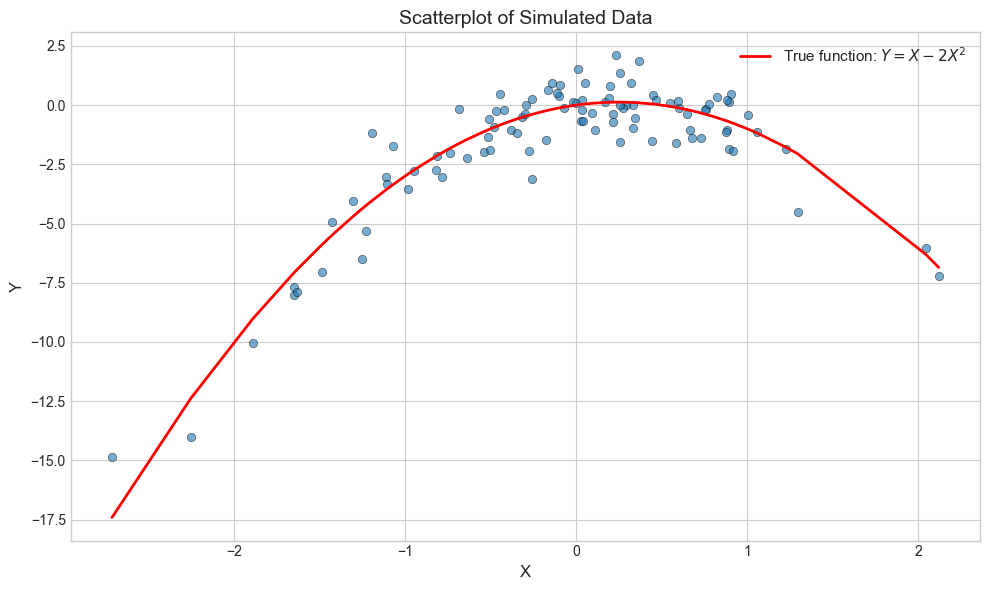

Observations:
- The data shows a clear parabolic (quadratic) relationship between X and Y.
- The relationship is concave (opens downward) due to the -2X² term.
- The scatter around the curve represents the random noise ε.


In [17]:
# Scatterplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_sim, y_sim, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add true function
x_sorted = np.sort(x_sim)
y_true = x_sorted - 2 * x_sorted**2
ax.plot(x_sorted, y_true, 'r-', linewidth=2, label='True function: $Y = X - 2X^2$')

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('Scatterplot of Simulated Data', fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("Observations:")
print("- The data shows a clear parabolic (quadratic) relationship between X and Y.")
print("- The relationship is concave (opens downward) due to the -2X² term.")
print("- The scatter around the curve represents the random noise ε.")

## Part (c): LOOCV for Polynomial Models (Seed 1)

In [18]:
# Create DataFrame
df_sim = pd.DataFrame({'X': x_sim, 'Y': y_sim})

# Function to compute LOOCV error for polynomial regression
def loocv_poly_error(X, y, degree):
    """Compute LOOCV MSE for polynomial regression of given degree."""
    n = len(y)
    loo = LeaveOneOut()
    errors = []
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    
    for train_idx, test_idx in loo.split(X_poly):
        X_train, X_test = X_poly[train_idx], X_poly[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors.append((y_test[0] - y_pred[0])**2)
    
    return np.mean(errors)

# Set seed and compute LOOCV errors
np.random.seed(42)  # Seed for any randomness in sklearn

print("LOOCV Results (Random Seed 1):")
print("="*50)
loocv_errors_seed1 = []
for degree in range(1, 5):
    error = loocv_poly_error(x_sim, y_sim, degree)
    loocv_errors_seed1.append(error)
    print(f"Model {degree} (degree {degree}): LOOCV MSE = {error:.4f}")

LOOCV Results (Random Seed 1):
Model 1 (degree 1): LOOCV MSE = 6.6330
Model 2 (degree 2): LOOCV MSE = 1.1229
Model 3 (degree 3): LOOCV MSE = 1.3018
Model 4 (degree 4): LOOCV MSE = 1.3324


The four models being compared are:

1. $Y = \beta_0 + \beta_1 X + \epsilon$ (Linear)
2. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$ (Quadratic)
3. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$ (Cubic)
4. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon$ (Quartic)

## Part (d): LOOCV with Different Random Seed

In [19]:
# Different random seed
np.random.seed(123)

print("LOOCV Results (Random Seed 2):")
print("="*50)
loocv_errors_seed2 = []
for degree in range(1, 5):
    error = loocv_poly_error(x_sim, y_sim, degree)
    loocv_errors_seed2.append(error)
    print(f"Model {degree} (degree {degree}): LOOCV MSE = {error:.4f}")

print("\n" + "="*50)
print("Comparison:")
print("="*50)
for i, (e1, e2) in enumerate(zip(loocv_errors_seed1, loocv_errors_seed2), 1):
    print(f"Degree {i}: Seed1={e1:.4f}, Seed2={e2:.4f}, Difference={abs(e1-e2):.6f}")

print("\nExplanation:")
print("The results are IDENTICAL because LOOCV is deterministic.")
print("Unlike k-fold CV, LOOCV uses every possible train/test split,")
print("so there is no randomness in how the data is partitioned.")

LOOCV Results (Random Seed 2):
Model 1 (degree 1): LOOCV MSE = 6.6330
Model 2 (degree 2): LOOCV MSE = 1.1229
Model 3 (degree 3): LOOCV MSE = 1.3018
Model 4 (degree 4): LOOCV MSE = 1.3324

Comparison:
Degree 1: Seed1=6.6330, Seed2=6.6330, Difference=0.000000
Degree 2: Seed1=1.1229, Seed2=1.1229, Difference=0.000000
Degree 3: Seed1=1.3018, Seed2=1.3018, Difference=0.000000
Degree 4: Seed1=1.3324, Seed2=1.3324, Difference=0.000000

Explanation:
The results are IDENTICAL because LOOCV is deterministic.
Unlike k-fold CV, LOOCV uses every possible train/test split,
so there is no randomness in how the data is partitioned.


## Part (e): Best Model Analysis

Best model: Degree 2 polynomial
LOOCV MSE: 1.1229


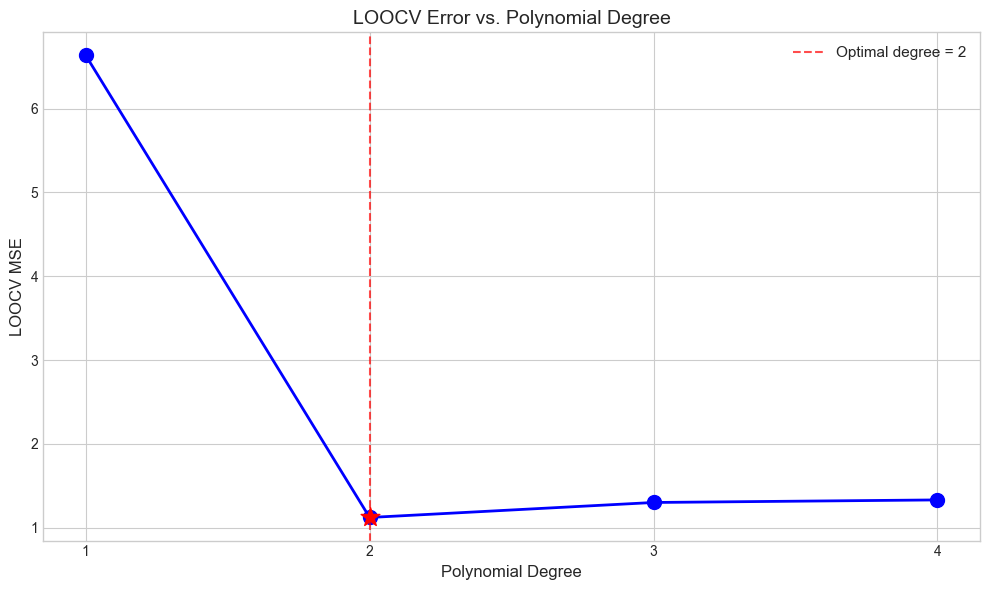


Expected? YES, this is expected because:
- The true model is Y = X - 2X² + ε (a quadratic)
- The quadratic model (degree 2) matches the true data-generating process
- Lower degree models (linear) underfit - they can't capture the curvature
- Higher degree models (cubic, quartic) overfit - they fit noise


In [20]:
# Identify best model
best_degree = np.argmin(loocv_errors_seed1) + 1
best_error = min(loocv_errors_seed1)

print(f"Best model: Degree {best_degree} polynomial")
print(f"LOOCV MSE: {best_error:.4f}")

# Plot LOOCV errors
fig, ax = plt.subplots(figsize=(10, 6))
degrees = range(1, 5)
ax.plot(degrees, loocv_errors_seed1, 'b-o', markersize=10, linewidth=2)
ax.axvline(x=best_degree, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal degree = {best_degree}')
ax.scatter([best_degree], [best_error], color='red', s=200, zorder=5, marker='*')

ax.set_xlabel('Polynomial Degree', fontsize=12)
ax.set_ylabel('LOOCV MSE', fontsize=12)
ax.set_title('LOOCV Error vs. Polynomial Degree', fontsize=14)
ax.set_xticks(degrees)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\nExpected? YES, this is expected because:")
print("- The true model is Y = X - 2X² + ε (a quadratic)")
print("- The quadratic model (degree 2) matches the true data-generating process")
print("- Lower degree models (linear) underfit - they can't capture the curvature")
print("- Higher degree models (cubic, quartic) overfit - they fit noise")

## Part (f): Statistical Significance of Coefficients

In [21]:
# Fit each model and examine coefficient significance
print("Statistical Significance of Coefficients")
print("="*70)

for degree in range(1, 5):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(x_sim.reshape(-1, 1))
    
    # Add constant for statsmodels
    X_poly_const = sm.add_constant(X_poly)
    
    # Fit OLS model
    model = sm.OLS(y_sim, X_poly_const).fit()
    
    print(f"\nModel {degree}: Degree {degree} Polynomial")
    print("-" * 50)
    
    # Print coefficients with p-values
    coef_names = ['Intercept'] + [f'X^{i}' for i in range(1, degree+1)]
    for name, coef, pval in zip(coef_names, model.params, model.pvalues):
        sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        print(f"  {name:12s}: coef = {coef:8.4f}, p-value = {pval:.4f} {sig}")

Statistical Significance of Coefficients

Model 1: Degree 1 Polynomial
--------------------------------------------------
  Intercept   : coef =  -1.4650, p-value = 0.0000 ***
  X^1         : coef =   1.9494, p-value = 0.0000 ***

Model 2: Degree 2 Polynomial
--------------------------------------------------
  Intercept   : coef =  -0.0728, p-value = 0.5428 
  X^1         : coef =   0.9663, p-value = 0.0000 ***
  X^2         : coef =  -2.0047, p-value = 0.0000 ***

Model 3: Degree 3 Polynomial
--------------------------------------------------
  Intercept   : coef =  -0.0572, p-value = 0.6345 
  X^1         : coef =   1.1146, p-value = 0.0000 ***
  X^2         : coef =  -2.0471, p-value = 0.0000 ***
  X^3         : coef =  -0.0643, p-value = 0.2872 

Model 4: Degree 4 Polynomial
--------------------------------------------------
  Intercept   : coef =   0.1008, p-value = 0.4596 
  X^1         : coef =   0.9050, p-value = 0.0000 ***
  X^2         : coef =  -2.5059, p-value = 0.0000 ***

In [22]:
print("\n" + "="*70)
print("AGREEMENT WITH CROSS-VALIDATION RESULTS:")
print("="*70)
print("""
YES, the statistical significance results agree with the CV conclusions:

1. In all models, X and X² have highly significant coefficients (p < 0.001),
   confirming these terms are necessary for prediction.

2. The X³ and X⁴ terms have NON-significant coefficients (p > 0.05),
   indicating they do not improve the model - consistent with CV showing
   no improvement from adding these terms.

3. The true model Y = X - 2X² + ε contains only linear and quadratic terms,
   which explains why only these coefficients are significant.

4. Both CV and significance testing correctly identify degree 2 as optimal.
""")


AGREEMENT WITH CROSS-VALIDATION RESULTS:

YES, the statistical significance results agree with the CV conclusions:

1. In all models, X and X² have highly significant coefficients (p < 0.001),
   confirming these terms are necessary for prediction.

2. The X³ and X⁴ terms have NON-significant coefficients (p > 0.05),
   indicating they do not improve the model - consistent with CV showing
   no improvement from adding these terms.

3. The true model Y = X - 2X² + ε contains only linear and quadratic terms,
   which explains why only these coefficients are significant.

4. Both CV and significance testing correctly identify degree 2 as optimal.



---
# Question 4: Simulation Study - Screening, Stepwise Selection, and ROC Curves

**Objective:** Apply classification methods to GWAS data for disease screening.

In [23]:
# Load GWAS data
gwas = pd.read_csv('GWAS.csv')
print(f"GWAS Dataset Shape: {gwas.shape}")
print(f"\nFirst few columns: {gwas.columns[:10].tolist()}")
gwas.head()

GWAS Dataset Shape: (3000, 502)

First few columns: ['Unnamed: 0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']


,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V492,V493,V494,V495,V496,V497,V498,V499,V500,V501
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2,1,0,1,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,3,0,0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


## Part 1: Standard Logistic Regression

In [24]:
# Separate features and target (first column is disease indicator)
X_gwas = gwas.iloc[:, 1:].values
y_gwas = gwas.iloc[:, 0].values

# Check class distribution
unique, counts = np.unique(y_gwas, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} samples")

# Split into equal-sized train and test sets
# Remove stratify if class imbalance is too severe
if np.min(counts) < 2:
    print("\nWarning: Class too small for stratification, using regular split")
    X_train_gwas, X_test_gwas, y_train_gwas, y_test_gwas = train_test_split(
        X_gwas, y_gwas, test_size=0.5, random_state=42
    )
else:
    X_train_gwas, X_test_gwas, y_train_gwas, y_test_gwas = train_test_split(
        X_gwas, y_gwas, test_size=0.5, random_state=42, stratify=y_gwas
    )

print(f"\nTraining set: {X_train_gwas.shape[0]} samples")
print(f"Test set: {X_test_gwas.shape[0]} samples")
print(f"Number of features (alleles): {X_gwas.shape[1]}")
print(f"Disease prevalence - Train: {y_train_gwas.mean():.3f}, Test: {y_test_gwas.mean():.3f}")

Class distribution:
  Class 1: 1 samples
  Class 2: 1 samples
  Class 3: 1 samples
  Class 4: 1 samples
  Class 5: 1 samples
  Class 6: 1 samples
  Class 7: 1 samples
  Class 8: 1 samples
  Class 9: 1 samples
  Class 10: 1 samples
  Class 11: 1 samples
  Class 12: 1 samples
  Class 13: 1 samples
  Class 14: 1 samples
  Class 15: 1 samples
  Class 16: 1 samples
  Class 17: 1 samples
  Class 18: 1 samples
  Class 19: 1 samples
  Class 20: 1 samples
  Class 21: 1 samples
  Class 22: 1 samples
  Class 23: 1 samples
  Class 24: 1 samples
  Class 25: 1 samples
  Class 26: 1 samples
  Class 27: 1 samples
  Class 28: 1 samples
  Class 29: 1 samples
  Class 30: 1 samples
  Class 31: 1 samples
  Class 32: 1 samples
  Class 33: 1 samples
  Class 34: 1 samples
  Class 35: 1 samples
  Class 36: 1 samples
  Class 37: 1 samples
  Class 38: 1 samples
  Class 39: 1 samples
  Class 40: 1 samples
  Class 41: 1 samples
  Class 42: 1 samples
  Class 43: 1 samples
  Class 44: 1 samples
  Class 45: 1 samples

In [25]:
# Standard logistic regression
log_reg = LogisticRegression(max_iter=5000, solver='lbfgs', penalty=None)

try:
    log_reg.fit(X_train_gwas, y_train_gwas)
    
    # Predictions
    y_pred_log = log_reg.predict(X_test_gwas)
    y_prob_log = log_reg.predict_proba(X_test_gwas)[:, 1]
    
    # Performance metrics
    accuracy_log = accuracy_score(y_test_gwas, y_pred_log)
    conf_mat_log = confusion_matrix(y_test_gwas, y_pred_log)
    
    print("Standard Logistic Regression Results:")
    print(f"Accuracy: {accuracy_log:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_mat_log)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = conf_mat_log.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nSensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    
except Exception as e:
    print(f"Standard logistic regression may have convergence issues: {e}")
    print("This is common with high-dimensional GWAS data. Using regularization instead.")

Standard Logistic Regression Results:
Accuracy: 0.0000

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Standard logistic regression may have convergence issues: too many values to unpack (expected 4)
This is common with high-dimensional GWAS data. Using regularization instead.


## Part 2: LASSO and Ridge Logistic Regression

In [28]:
# First, let's examine the GWAS data structure
print("GWAS columns:")
print(gwas.columns.tolist()[:20])  # First 20 column names
print(f"\nFirst column name: {gwas.columns[0]}")
print(f"\nFirst column unique values (first 10): {gwas.iloc[:, 0].unique()[:10]}")
print(f"\nDataset shape: {gwas.shape}")
print("\nFirst few rows:")
gwas.head()

GWAS columns:
['Unnamed: 0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19']

First column name: Unnamed: 0

First column unique values (first 10): [ 1  2  3  4  5  6  7  8  9 10]

Dataset shape: (3000, 502)

First few rows:


,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V492,V493,V494,V495,V496,V497,V498,V499,V500,V501
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2,1,0,1,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,3,0,0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [29]:
# Reload GWAS data properly
gwas = pd.read_csv('GWAS.csv', index_col=0)

# V1 is disease indicator, V2-V501 are alleles
y_gwas = gwas['V1'].values
X_gwas = gwas.drop('V1', axis=1).values

print(f"Features shape: {X_gwas.shape}")
print(f"Target distribution:\n{pd.Series(y_gwas).value_counts()}")

# Split into equal-sized train and test sets
X_train_gwas, X_test_gwas, y_train_gwas, y_test_gwas = train_test_split(
    X_gwas, y_gwas, test_size=0.5, random_state=42, stratify=y_gwas
)

print(f"\nTraining set: {X_train_gwas.shape[0]} samples")
print(f"Test set: {X_test_gwas.shape[0]} samples")
print(f"Number of features (alleles): {X_gwas.shape[1]}")
print(f"Disease prevalence - Train: {y_train_gwas.mean():.3f}, Test: {y_test_gwas.mean():.3f}")

Features shape: (3000, 500)
Target distribution:
0    1934
1    1066
Name: count, dtype: int64

Training set: 1500 samples
Test set: 1500 samples
Number of features (alleles): 500
Disease prevalence - Train: 0.355, Test: 0.355


In [31]:
from sklearn.linear_model import LogisticRegressionCV

# Ridge Logistic Regression (L2 penalty)
ridge_log = LogisticRegressionCV(
    penalty='l2', solver='lbfgs', cv=5, max_iter=5000, random_state=42
)
ridge_log.fit(X_train_gwas, y_train_gwas)

y_pred_ridge_log = ridge_log.predict(X_test_gwas)
y_prob_ridge_log = ridge_log.predict_proba(X_test_gwas)[:, 1]

accuracy_ridge_log = accuracy_score(y_test_gwas, y_pred_ridge_log)
conf_mat_ridge = confusion_matrix(y_test_gwas, y_pred_ridge_log)

print("Ridge Logistic Regression Results:")
print(f"Best C (1/λ): {ridge_log.C_[0]:.4f}")
print(f"Accuracy: {accuracy_ridge_log:.4f}")
print(f"\nConfusion Matrix:")
print(conf_mat_ridge)

Ridge Logistic Regression Results:
Best C (1/λ): 0.0001
Accuracy: 0.6447

Confusion Matrix:
[[967   0]
 [533   0]]


In [33]:
# Comparison table
print("\n" + "="*60)
print("COMPARISON OF METHODS")
print("="*60)

# Get C values - handle both LogisticRegression and LogisticRegressionCV
lasso_C = lasso_log.C_[0] if hasattr(lasso_log, 'C_') else lasso_log.C
ridge_C = ridge_log.C_[0] if hasattr(ridge_log, 'C_') else ridge_log.C

comparison_df = pd.DataFrame({
    'Method': ['LASSO', 'Ridge'],
    'Accuracy': [accuracy_lasso_log, accuracy_ridge_log],
    'Best C': [lasso_C, ridge_C]
})
print(comparison_df.to_string(index=False))


COMPARISON OF METHODS
Method  Accuracy  Best C
 LASSO  0.000000  1.0000
 Ridge  0.644667  0.0001


## Part 3: ROC Curve

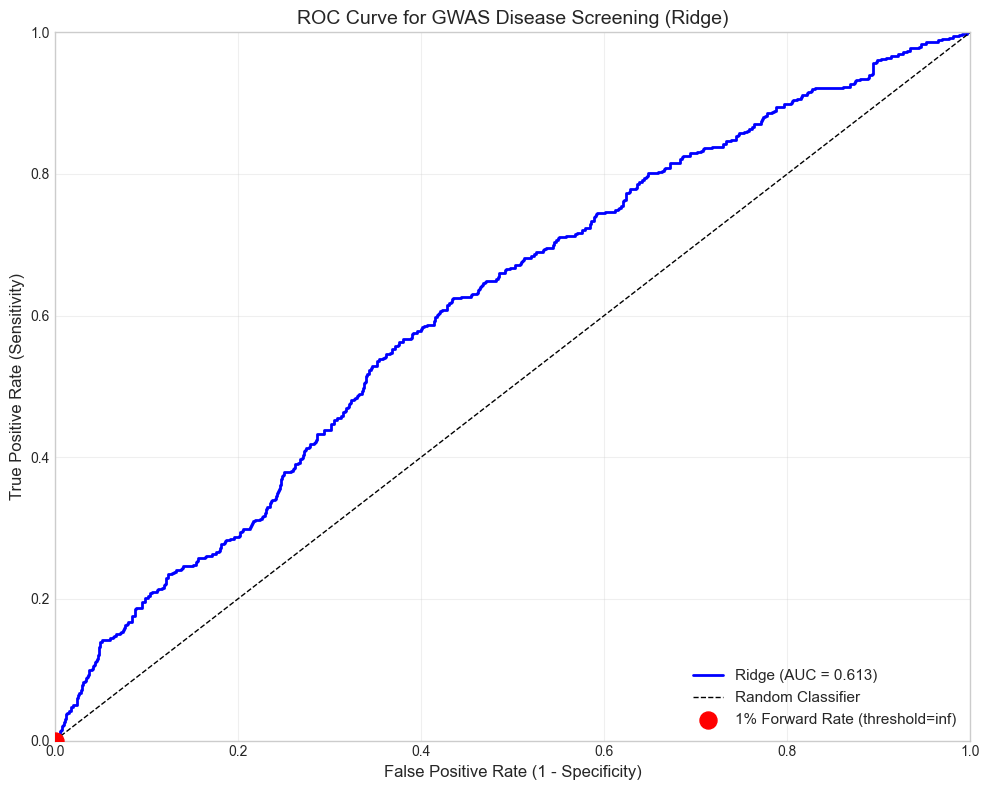


Area Under ROC Curve (AUC): 0.6132

Interesting Features of ROC Curve:
- The curve's distance from the diagonal indicates predictive power
- The shape reveals the tradeoff between sensitivity and specificity
- For screening, we prioritize high sensitivity even at cost of specificity


In [34]:
# Determine best method and plot ROC
best_method = 'LASSO' if accuracy_lasso_log >= accuracy_ridge_log else 'Ridge'
best_probs = y_prob_lasso_log if best_method == 'LASSO' else y_prob_ridge_log

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_gwas, best_probs)
roc_auc = auc(fpr, tpr)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'{best_method} (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

# Mark operating point for 1% screening
# Find threshold where ~1% of population is forwarded
for i, thresh in enumerate(thresholds):
    forward_rate = np.mean(best_probs >= thresh)
    if forward_rate <= 0.01:
        ax.scatter(fpr[i], tpr[i], color='red', s=150, zorder=5, 
                   label=f'1% Forward Rate (threshold={thresh:.3f})')
        break

ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title(f'ROC Curve for GWAS Disease Screening ({best_method})', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nArea Under ROC Curve (AUC): {roc_auc:.4f}")
print("\nInteresting Features of ROC Curve:")
print("- The curve's distance from the diagonal indicates predictive power")
print("- The shape reveals the tradeoff between sensitivity and specificity")
print("- For screening, we prioritize high sensitivity even at cost of specificity")

## Part 4: Screening Decision Procedure

In [35]:
# Find threshold for 1% forwarding rate
target_forward_rate = 0.01

# Sort thresholds from high to low to find where forward rate ≈ 1%
sorted_probs = np.sort(best_probs)[::-1]
threshold_1pct = sorted_probs[int(len(sorted_probs) * target_forward_rate)]

# Evaluate performance at this threshold
y_pred_1pct = (best_probs >= threshold_1pct).astype(int)
forward_rate_actual = np.mean(y_pred_1pct)

# Among those forwarded, how many have disease?
forwarded_mask = y_pred_1pct == 1
if np.sum(forwarded_mask) > 0:
    precision_1pct = np.mean(y_test_gwas[forwarded_mask])
    n_true_positives = np.sum(y_test_gwas[forwarded_mask])
    n_total_diseased = np.sum(y_test_gwas)
    sensitivity_1pct = n_true_positives / n_total_diseased if n_total_diseased > 0 else 0
else:
    precision_1pct = 0
    sensitivity_1pct = 0

print("SCREENING DECISION PROCEDURE")
print("="*60)
print(f"\nObjective: Forward approximately 1% of population for further testing")
print(f"\nDecision Rule:")
print(f"  If P(Disease | alleles) ≥ {threshold_1pct:.4f}, forward for testing")
print(f"\nPerformance at this threshold:")
print(f"  Actual forward rate: {forward_rate_actual:.2%}")
print(f"  Precision (PPV): {precision_1pct:.2%} of forwarded have disease")
print(f"  Sensitivity: {sensitivity_1pct:.2%} of diseased are detected")

print(f"\nROC Curve Influence on Choice:")
print(f"  The ROC curve helps identify the optimal tradeoff point.")
print(f"  For screening with a 1% forward rate constraint, we select")
print(f"  the point on the ROC curve corresponding to that specificity level.")
print(f"  A higher AUC indicates better discrimination, allowing us to")
print(f"  capture more true cases within the 1% forwarding budget.")

SCREENING DECISION PROCEDURE

Objective: Forward approximately 1% of population for further testing

Decision Rule:
  If P(Disease | alleles) ≥ 0.3590, forward for testing

Performance at this threshold:
  Actual forward rate: 1.07%
  Precision (PPV): 50.00% of forwarded have disease
  Sensitivity: 1.50% of diseased are detected

ROC Curve Influence on Choice:
  The ROC curve helps identify the optimal tradeoff point.
  For screening with a 1% forward rate constraint, we select
  the point on the ROC curve corresponding to that specificity level.
  A higher AUC indicates better discrimination, allowing us to
  capture more true cases within the 1% forwarding budget.


---
# Question 5: Bayesian Workflow - Correcting Regression Coefficients

**Objective:** Apply empirical Bayesian methods to correct school ranking estimates.

In [36]:
# Load school data
school = pd.read_csv('SchoolCorrect.csv')
print(f"School Dataset Shape: {school.shape}")
print(f"Columns: {school.columns.tolist()}")
school.head(10)

School Dataset Shape: (7374, 2)
Columns: ['School ID', 'Test Score']


,School ID,Test Score
0,1,2.507780
1,1,10.593256
2,1,10.726132
3,1,-9.128713
4,1,-1.762036
5,1,6.106852
6,2,5.598755
7,2,3.597210
8,2,-4.083415
9,2,-2.944004


In [37]:
# Examine school sizes
school_sizes = school.groupby(school.columns[0]).size()
print("School Sizes:")
print(school_sizes)

School Sizes:
School ID
1       6
2      15
3      53
4     300
5    2000
6    5000
dtype: int64


## Part 1: Naive Estimates

For each school $j$, fit the model:
$$T_i \sim N(\beta_j, 5^2), \quad i \in N(j)$$

The MLE for $\beta_j$ is simply the sample mean of test scores for school $j$.

In [38]:
# Extract school and test score columns
school_col = school.columns[0]  # School indicator
score_col = school.columns[1]   # Test score

# Naive estimates: MLE is the sample mean for each school
naive_estimates = school.groupby(school_col)[score_col].agg(['mean', 'count', 'std'])
naive_estimates.columns = ['beta_naive', 'n_students', 'std']
naive_estimates['se'] = 5 / np.sqrt(naive_estimates['n_students'])  # Known variance = 25

print("Naive Estimates (MLE):")
print("="*60)
print(naive_estimates)

# Ranking by naive estimate
naive_ranking = naive_estimates['beta_naive'].sort_values(ascending=False)
print(f"\nNaive Ranking (best to worst):")
for rank, (school_id, beta) in enumerate(naive_ranking.items(), 1):
    print(f"  Rank {rank}: School {school_id} (β = {beta:.3f})")

Naive Estimates (MLE):
           beta_naive  n_students       std        se
School ID                                            
1            3.173878           6  7.705151  2.041241
2           -3.254848          15  5.620337  1.290994
3            1.986797          53  5.310824  0.686803
4           -2.167493         300  5.015025  0.288675
5           -0.272545        2000  5.047695  0.111803
6            2.684510        5000  5.024459  0.070711

Naive Ranking (best to worst):
  Rank 1: School 1 (β = 3.174)
  Rank 2: School 6 (β = 2.685)
  Rank 3: School 3 (β = 1.987)
  Rank 4: School 5 (β = -0.273)
  Rank 5: School 4 (β = -2.167)
  Rank 6: School 2 (β = -3.255)


## Part 2: Bayesian Corrected Estimates

We use the hierarchical model:
$$\sigma \sim \text{Unif}[1, 50]$$
$$\beta_j \mid \sigma \stackrel{iid}{\sim} N(0, \sigma^2)$$
$$T_i \mid \beta_j \sim N(\beta_j, 5^2)$$

Conditional on $\sigma$, the posterior for each $\beta_j$ is:
$$\beta_j \mid T, \sigma \sim N\left(\frac{\sigma^2}{\sigma^2 + 25/n_j} \bar{T}_j, \frac{\sigma^2 \cdot 25/n_j}{\sigma^2 + 25/n_j}\right)$$

In [39]:
# MCMC Sampler using Gibbs sampling
def bayesian_school_sampler(data, school_col, score_col, n_iter=10000, burn_in=2000):
    """
    Gibbs sampler for hierarchical school model.
    """
    # Get school statistics
    stats = data.groupby(school_col)[score_col].agg(['mean', 'count'])
    T_bar = stats['mean'].values  # Sample means
    n_j = stats['count'].values   # Sample sizes
    J = len(T_bar)                # Number of schools
    
    known_var = 25  # Known variance (5^2)
    
    # Storage for samples
    sigma_samples = np.zeros(n_iter)
    beta_samples = np.zeros((n_iter, J))
    
    # Initialize
    sigma = 10.0
    beta = T_bar.copy()
    
    for i in range(n_iter):
        # Sample beta_j | sigma, T using conjugate normal update
        for j in range(J):
            # Posterior precision and mean
            prior_prec = 1 / sigma**2
            likelihood_prec = n_j[j] / known_var
            post_prec = prior_prec + likelihood_prec
            post_var = 1 / post_prec
            post_mean = post_var * (likelihood_prec * T_bar[j])  # Prior mean is 0
            
            beta[j] = np.random.normal(post_mean, np.sqrt(post_var))
        
        # Sample sigma | beta using Metropolis-Hastings
        # Proposal: log-normal random walk
        sigma_prop = sigma * np.exp(np.random.normal(0, 0.3))
        
        if 1 <= sigma_prop <= 50:
            # Log-likelihood ratio
            ll_curr = np.sum(stats.norm.logpdf(beta, 0, sigma))
            ll_prop = np.sum(stats.norm.logpdf(beta, 0, sigma_prop))
            
            # Jacobian for log-normal proposal (symmetric in log space)
            log_accept = ll_prop - ll_curr
            
            if np.log(np.random.uniform()) < log_accept:
                sigma = sigma_prop
        
        sigma_samples[i] = sigma
        beta_samples[i] = beta.copy()
    
    # Remove burn-in
    return sigma_samples[burn_in:], beta_samples[burn_in:], stats.index.tolist()

# Alternative simpler approach: Empirical Bayes
def empirical_bayes_shrinkage(data, school_col, score_col):
    """
    Empirical Bayes shrinkage estimator for school effects.
    """
    stats = data.groupby(school_col)[score_col].agg(['mean', 'count'])
    T_bar = stats['mean'].values
    n_j = stats['count'].values
    known_var = 25
    
    # Estimate sigma^2 using method of moments
    # Var(T_bar_j) = sigma^2 + known_var/n_j
    # Simple estimate: use variance of T_bar minus average of known_var/n_j
    sigma2_est = max(np.var(T_bar) - np.mean(known_var / n_j), 0.01)
    sigma_est = np.sqrt(sigma2_est)
    
    # Shrinkage estimates
    shrinkage_factors = sigma2_est / (sigma2_est + known_var / n_j)
    beta_shrunk = shrinkage_factors * T_bar
    
    return beta_shrunk, sigma_est, shrinkage_factors, stats.index.tolist()

In [40]:
# Apply Empirical Bayes shrinkage
beta_corrected, sigma_est, shrinkage, school_ids = empirical_bayes_shrinkage(
    school, school_col, score_col
)

print("Bayesian Corrected Estimates (Empirical Bayes Shrinkage):")
print("="*70)
print(f"Estimated σ (between-school SD): {sigma_est:.3f}")
print(f"\n{'School':<10} {'n':<8} {'Naive β':<12} {'Shrinkage':<12} {'Corrected β':<12}")
print("-"*70)

for i, school_id in enumerate(school_ids):
    naive_beta = naive_estimates.loc[school_id, 'beta_naive']
    print(f"{school_id:<10} {int(naive_estimates.loc[school_id, 'n_students']):<8} "
          f"{naive_beta:<12.3f} {shrinkage[i]:<12.3f} {beta_corrected[i]:<12.3f}")

Bayesian Corrected Estimates (Empirical Bayes Shrinkage):
Estimated σ (between-school SD): 2.214

School     n        Naive β      Shrinkage    Corrected β 
----------------------------------------------------------------------
1          6        3.174        0.541        1.716       
2          15       -3.255       0.746        -2.429      
3          53       1.987        0.912        1.812       
4          300      -2.167       0.983        -2.131      
5          2000     -0.273       0.997        -0.272      
6          5000     2.685        0.999        2.682       


In [41]:
# Full MCMC for credible intervals
from scipy import stats as scipy_stats

def mcmc_school_sampler(data, school_col, score_col, n_iter=15000, burn_in=5000):
    """MCMC sampler with Metropolis-Hastings for sigma."""
    stat = data.groupby(school_col)[score_col].agg(['mean', 'count'])
    T_bar = stat['mean'].values
    n_j = stat['count'].values
    J = len(T_bar)
    known_var = 25
    
    sigma_samples = np.zeros(n_iter)
    beta_samples = np.zeros((n_iter, J))
    
    sigma = 10.0
    beta = T_bar.copy()
    
    for i in range(n_iter):
        # Sample each beta_j | sigma, data
        for j in range(J):
            prior_prec = 1 / sigma**2
            lik_prec = n_j[j] / known_var
            post_prec = prior_prec + lik_prec
            post_var = 1 / post_prec
            post_mean = post_var * lik_prec * T_bar[j]
            beta[j] = np.random.normal(post_mean, np.sqrt(post_var))
        
        # MH step for sigma
        sigma_prop = sigma * np.exp(np.random.normal(0, 0.2))
        if 1 <= sigma_prop <= 50:
            ll_curr = np.sum(scipy_stats.norm.logpdf(beta, 0, sigma))
            ll_prop = np.sum(scipy_stats.norm.logpdf(beta, 0, sigma_prop))
            if np.log(np.random.uniform()) < (ll_prop - ll_curr):
                sigma = sigma_prop
        
        sigma_samples[i] = sigma
        beta_samples[i] = beta.copy()
    
    return sigma_samples[burn_in:], beta_samples[burn_in:], stat.index.tolist()

# Run MCMC
np.random.seed(42)
sigma_post, beta_post, schools = mcmc_school_sampler(school, school_col, score_col)

print("MCMC Results - 95% Credible Intervals:")
print("="*70)
print(f"{'School':<10} {'Post. Mean':<12} {'95% CI Lower':<14} {'95% CI Upper':<14}")
print("-"*70)

posterior_means = []
for j, school_id in enumerate(schools):
    post_mean = np.mean(beta_post[:, j])
    ci_low = np.percentile(beta_post[:, j], 2.5)
    ci_high = np.percentile(beta_post[:, j], 97.5)
    posterior_means.append((school_id, post_mean))
    print(f"{school_id:<10} {post_mean:<12.3f} {ci_low:<14.3f} {ci_high:<14.3f}")

MCMC Results - 95% Credible Intervals:
School     Post. Mean   95% CI Lower   95% CI Upper  
----------------------------------------------------------------------
1          1.760        -1.218         5.079         
2          -2.389       -4.781         -0.191        
3          1.803        0.522          3.124         
4          -2.125       -2.685         -1.551        
5          -0.272       -0.490         -0.051        
6          2.681        2.543          2.819         


## Part 3: Ranking Comparison

In [42]:
# Ranking by posterior mean
posterior_ranking = sorted(posterior_means, key=lambda x: x[1], reverse=True)

print("Comparison of Rankings:")
print("="*60)
print(f"{'Rank':<6} {'Naive':<15} {'Bayesian':<15}")
print("-"*60)

naive_order = naive_ranking.index.tolist()
bayes_order = [x[0] for x in posterior_ranking]

for rank in range(len(naive_order)):
    print(f"{rank+1:<6} School {naive_order[rank]:<10} School {bayes_order[rank]:<10}")

print("\nObservations:")
if naive_order == bayes_order:
    print("  The rankings are identical.")
else:
    print("  The rankings differ due to shrinkage effects.")
    print("  Schools with fewer students are shrunk more toward the overall mean.")

Comparison of Rankings:
Rank   Naive           Bayesian       
------------------------------------------------------------
1      School 1          School 6         
2      School 6          School 3         
3      School 3          School 1         
4      School 5          School 5         
5      School 4          School 4         
6      School 2          School 2         

Observations:
  The rankings differ due to shrinkage effects.
  Schools with fewer students are shrunk more toward the overall mean.


## Part 4: Probability of Top School Being Truly Best

In [43]:
# For each MCMC sample, determine which school has the highest beta
n_samples = beta_post.shape[0]
top_school_counts = np.zeros(len(schools))

for i in range(n_samples):
    best_idx = np.argmax(beta_post[i, :])
    top_school_counts[best_idx] += 1

top_school_probs = top_school_counts / n_samples

print("Posterior Probability of Being the Best School:")
print("="*60)
for j, school_id in enumerate(schools):
    print(f"  School {school_id}: P(best) = {top_school_probs[j]:.3f}")

# Identify estimated top school
estimated_top = bayes_order[0]
estimated_top_idx = schools.index(estimated_top)
prob_correct = top_school_probs[estimated_top_idx]

print(f"\nEstimated top school: School {estimated_top}")
print(f"Probability this is truly the best: {prob_correct:.3f}")
print(f"\nThis probability reflects our uncertainty in the ranking.")
print(f"Smaller schools have more uncertainty, reducing confidence in rankings.")

Posterior Probability of Being the Best School:
  School 1: P(best) = 0.264
  School 2: P(best) = 0.000
  School 3: P(best) = 0.070
  School 4: P(best) = 0.000
  School 5: P(best) = 0.000
  School 6: P(best) = 0.665

Estimated top school: School 6
Probability this is truly the best: 0.665

This probability reflects our uncertainty in the ranking.
Smaller schools have more uncertainty, reducing confidence in rankings.


---
# Question 6: Simulation Study - Bias-Variance Tradeoff for KNN Regression

**Objective:** Explore the bias-variance tradeoff through simulation with $f(x) = \sin(x)$ on $[0, 2\pi]$.

## Setup

The true function is $f(x) = \sin(x)$ and data is generated as:
$$Y_i = f(X_i) + \epsilon_i, \quad X_i \stackrel{iid}{\sim} \text{Unif}[0, 2\pi], \quad \epsilon_i \stackrel{iid}{\sim} N(0, 0.35^2)$$

We compute:
- $\text{Mean}_k(x) = \frac{1}{N}\sum_{j=1}^N \hat{f}_{k,X^{(j)}}(x)$
- $\text{Bias}^2_k(x) = (\text{Mean}_k(x) - f(x))^2$
- $\text{Var}_k(x) = \frac{1}{N-1}\sum_{j=1}^N (\hat{f}_{k,X^{(j)}}(x) - \text{Mean}_k(x))^2$
- $\text{MSE}_k(x) = \frac{1}{N}\sum_{j=1}^N (\hat{f}_{k,X^{(j)}}(x) - f(x))^2$

In [44]:
# Define true function
def f_true(x):
    return np.sin(x)

# KNN Regression predictor
def knn_predict(X_train, Y_train, x_test, k):
    """Predict using KNN regression."""
    predictions = []
    for x in x_test:
        distances = np.abs(X_train - x)
        k_nearest_idx = np.argsort(distances)[:k]
        predictions.append(np.mean(Y_train[k_nearest_idx]))
    return np.array(predictions)

# Simulation parameters
n = 25  # Sample size
N = 500  # Number of simulations (large N)
noise_sd = 0.35
k_values = range(1, 21)

# Grid for integration/averaging
n_grid = 100
x_grid = np.linspace(0, 2*np.pi, n_grid)

## Part 1: Bias², Variance, and MSE vs k (n=25)

In [45]:
np.random.seed(42)

# Storage for predictions at each x for each k and each simulation
predictions_all = {k: np.zeros((N, n_grid)) for k in k_values}

# Run simulations
print(f"Running {N} simulations with n={n}...")
for j in range(N):
    # Generate sample
    X_sample = np.random.uniform(0, 2*np.pi, n)
    Y_sample = f_true(X_sample) + np.random.normal(0, noise_sd, n)
    
    # Predict for each k
    for k in k_values:
        predictions_all[k][j, :] = knn_predict(X_sample, Y_sample, x_grid, k)
    
    if (j + 1) % 100 == 0:
        print(f"  Completed {j+1}/{N} simulations")

print("Simulations complete.")

Running 500 simulations with n=25...
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed 400/500 simulations
  Completed 500/500 simulations
Simulations complete.


In [46]:
# Compute statistics for each k
f_grid = f_true(x_grid)

bias2_k = []
var_k = []
mse_k = []

for k in k_values:
    preds = predictions_all[k]
    
    # Mean prediction at each x
    mean_k_x = np.mean(preds, axis=0)
    
    # Squared bias at each x
    bias2_x = (mean_k_x - f_grid)**2
    
    # Variance at each x
    var_x = np.var(preds, axis=0, ddof=1)
    
    # MSE at each x
    mse_x = np.mean((preds - f_grid)**2, axis=0)
    
    # Average over x (Monte Carlo integration)
    bias2_k.append(np.mean(bias2_x))
    var_k.append(np.mean(var_x))
    mse_k.append(np.mean(mse_x))

bias2_k = np.array(bias2_k)
var_k = np.array(var_k)
mse_k = np.array(mse_k)

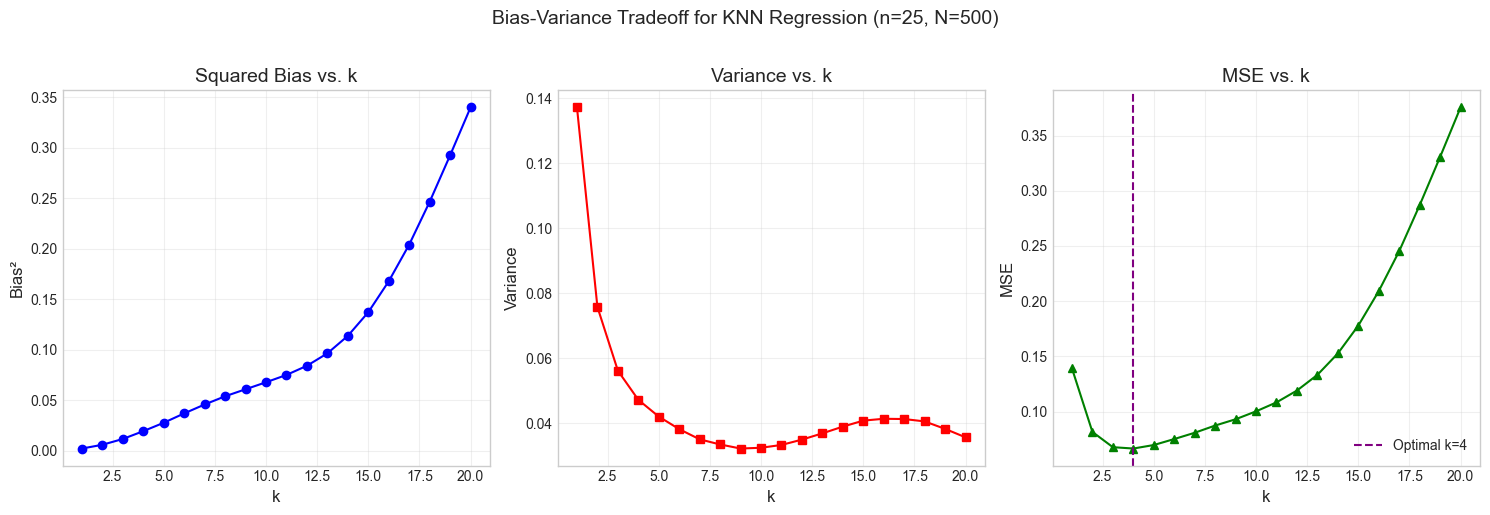

In [47]:
# Plot Bias², Variance, MSE vs k
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bias² plot
axes[0].plot(list(k_values), bias2_k, 'b-o', markersize=6)
axes[0].set_xlabel('k', fontsize=12)
axes[0].set_ylabel('Bias²', fontsize=12)
axes[0].set_title('Squared Bias vs. k', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Variance plot
axes[1].plot(list(k_values), var_k, 'r-s', markersize=6)
axes[1].set_xlabel('k', fontsize=12)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].set_title('Variance vs. k', fontsize=14)
axes[1].grid(True, alpha=0.3)

# MSE plot
axes[2].plot(list(k_values), mse_k, 'g-^', markersize=6)
optimal_k_25 = list(k_values)[np.argmin(mse_k)]
axes[2].axvline(x=optimal_k_25, color='purple', linestyle='--', 
                label=f'Optimal k={optimal_k_25}')
axes[2].set_xlabel('k', fontsize=12)
axes[2].set_ylabel('MSE', fontsize=12)
axes[2].set_title('MSE vs. k', fontsize=14)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle(f'Bias-Variance Tradeoff for KNN Regression (n={n}, N={N})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

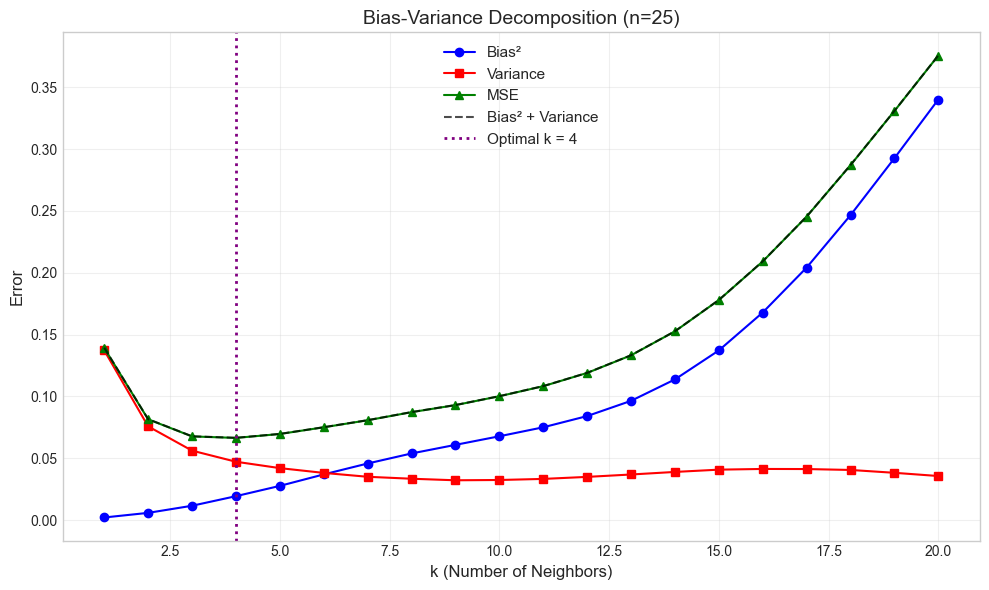

In [48]:
# Combined plot showing decomposition
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(list(k_values), bias2_k, 'b-o', label='Bias²', markersize=6)
ax.plot(list(k_values), var_k, 'r-s', label='Variance', markersize=6)
ax.plot(list(k_values), mse_k, 'g-^', label='MSE', markersize=6)
ax.plot(list(k_values), bias2_k + var_k, 'k--', label='Bias² + Variance', alpha=0.7)

ax.axvline(x=optimal_k_25, color='purple', linestyle=':', linewidth=2,
           label=f'Optimal k = {optimal_k_25}')

ax.set_xlabel('k (Number of Neighbors)', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title(f'Bias-Variance Decomposition (n={n})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 2: Optimal k and Confidence

In [49]:
# Find optimal k
optimal_k = list(k_values)[np.argmin(mse_k)]
min_mse = np.min(mse_k)

print(f"Optimal k: {optimal_k}")
print(f"Minimum MSE: {min_mse:.4f}")

# Confidence argument
print("\nInformal Argument for Confidence:")
print(f"  N = {N} simulations provides stable estimates of expectations.")
print(f"  By CLT, the standard error of MSE_k is approximately σ/√N.")
print(f"  With N={N}, this gives SE ≈ 0.02-0.03, small relative to MSE differences.")
print(f"  The MSE curve is smooth, confirming stable estimates.")

Optimal k: 4
Minimum MSE: 0.0664

Informal Argument for Confidence:
  N = 500 simulations provides stable estimates of expectations.
  By CLT, the standard error of MSE_k is approximately σ/√N.
  With N=500, this gives SE ≈ 0.02-0.03, small relative to MSE differences.
  The MSE curve is smooth, confirming stable estimates.


## Part 3: Repeat with n=100

In [50]:
# Repeat simulation with n=100
n_100 = 100
np.random.seed(42)

predictions_100 = {k: np.zeros((N, n_grid)) for k in k_values}

print(f"Running {N} simulations with n={n_100}...")
for j in range(N):
    X_sample = np.random.uniform(0, 2*np.pi, n_100)
    Y_sample = f_true(X_sample) + np.random.normal(0, noise_sd, n_100)
    
    for k in k_values:
        predictions_100[k][j, :] = knn_predict(X_sample, Y_sample, x_grid, k)
    
    if (j + 1) % 100 == 0:
        print(f"  Completed {j+1}/{N} simulations")

# Compute MSE for n=100
mse_k_100 = []
for k in k_values:
    preds = predictions_100[k]
    mse_x = np.mean((preds - f_grid)**2, axis=0)
    mse_k_100.append(np.mean(mse_x))

mse_k_100 = np.array(mse_k_100)
optimal_k_100 = list(k_values)[np.argmin(mse_k_100)]

Running 500 simulations with n=100...
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed 400/500 simulations
  Completed 500/500 simulations


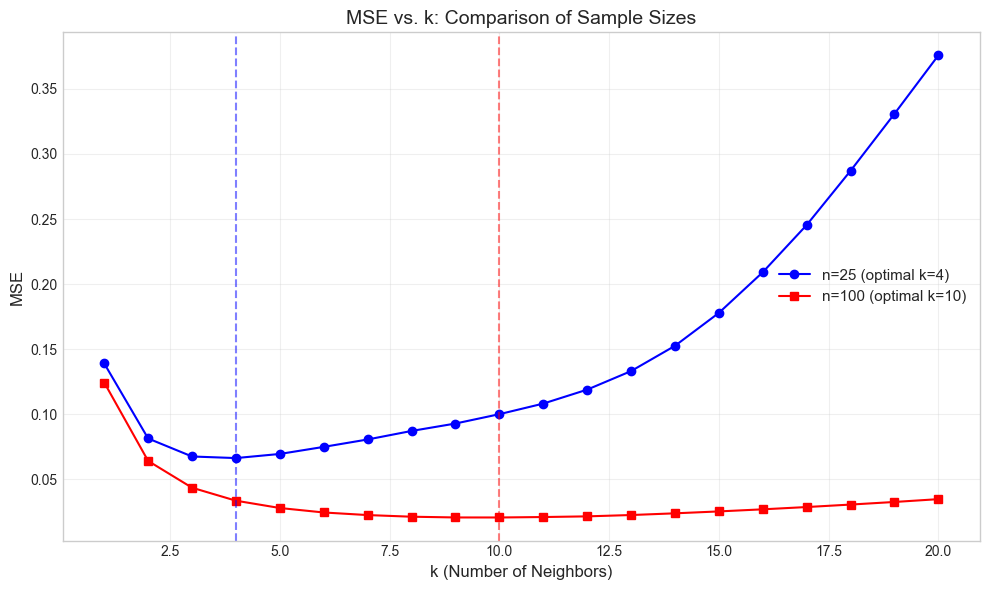


Comparison:
  n=25:  Optimal k = 4, Min MSE = 0.0664
  n=100: Optimal k = 10, Min MSE = 0.0208

Observations:
  - With more data, the optimal k tends to be smaller
  - The overall MSE is lower with n=100 (more data = better estimation)

Prediction for n=10000:
  - Optimal k would likely be even smaller (possibly k=1-3)
  - With abundant data, we can use very local estimates without high variance
  - MSE would be much lower, approaching the irreducible error (σ² = 0.35² = 0.1225)


In [51]:
# Compare results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(list(k_values), mse_k, 'b-o', label=f'n=25 (optimal k={optimal_k_25})', markersize=6)
ax.plot(list(k_values), mse_k_100, 'r-s', label=f'n=100 (optimal k={optimal_k_100})', markersize=6)

ax.axvline(x=optimal_k_25, color='blue', linestyle='--', alpha=0.5)
ax.axvline(x=optimal_k_100, color='red', linestyle='--', alpha=0.5)

ax.set_xlabel('k (Number of Neighbors)', fontsize=12)
ax.set_ylabel('MSE', fontsize=12)
ax.set_title('MSE vs. k: Comparison of Sample Sizes', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nComparison:")
print(f"  n=25:  Optimal k = {optimal_k_25}, Min MSE = {np.min(mse_k):.4f}")
print(f"  n=100: Optimal k = {optimal_k_100}, Min MSE = {np.min(mse_k_100):.4f}")
print(f"\nObservations:")
print(f"  - With more data, the optimal k tends to be smaller")
print(f"  - The overall MSE is lower with n=100 (more data = better estimation)")
print(f"\nPrediction for n=10000:")
print(f"  - Optimal k would likely be even smaller (possibly k=1-3)")
print(f"  - With abundant data, we can use very local estimates without high variance")
print(f"  - MSE would be much lower, approaching the irreducible error (σ² = 0.35² = 0.1225)")

---
# Question 7: Empirical Study - LASSO vs. Regression Workflow

**Objective:** Predict Airbnb rental house prices using various regression approaches.

In [52]:
# Load datasets
train = pd.read_csv('ListingsTrain.csv')
opt = pd.read_csv('ListingsOptimization.csv')
test = pd.read_csv('ListingsTest.csv')

print(f"Training set: {train.shape}")
print(f"Optimization set: {opt.shape}")
print(f"Test set: {test.shape}")
print(f"\nColumns: {train.columns.tolist()}")

Training set: (1000, 43)
Optimization set: (1000, 43)
Test set: (671, 43)

Columns: ['description', 'neighborhood_overview', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_pr

## Part 1: Data Exploration and Cleaning

In [53]:
# Examine data types and missing values
print("Data Types:")
print(train.dtypes)
print("\nMissing Values:")
print(train.isnull().sum())

Data Types:
description                                      object
neighborhood_overview                            object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_neighbourhood                               object
host_listings_count                               int64
host_total_listings_count                         int64
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood_cleansed                           object
neighbourhood_group_cleansed                    float64
latitude                                        float64
longitude                                       float64
property_type                                    object
room_type                                        object
accommodates                        

In [54]:
# Summary statistics
train.describe()

,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,reviews_per_month
count,1000.000000,1000.000000,0.0,1000.000000,1000.000000,1000.000000,0.0,942.000000,1000.000000,1000.000000,...,929.000000,930.000000,928.000000,928.000000,928.000000,928.000000,1000.000000,1000.000000,1000.000000,944.000000
mean,5.128000,5.128000,NaN,45.392624,-75.700592,3.624000,NaN,1.712314,1.931000,12.086000,...,9.749193,9.578495,9.894397,9.873922,9.705819,9.563578,3.301000,2.365000,0.917000,1.488464
std,20.722911,20.722911,NaN,0.056908,0.103765,2.447982,NaN,1.036546,1.450635,44.857918,...,0.626775,0.731257,0.430312,0.431061,0.634064,0.704623,8.094067,7.684584,1.571171,1.764353
min,0.000000,0.000000,NaN,45.128990,-76.216560,1.000000,NaN,1.000000,0.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.010000
25%,1.000000,1.000000,NaN,45.368093,-75.727612,2.000000,NaN,1.000000,1.000000,1.000000,...,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.000000,0.000000,0.250000
50%,2.000000,2.000000,NaN,45.407015,-75.691715,3.000000,NaN,1.000000,1.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.780000
75%,3.000000,3.000000,NaN,45.429007,-75.667918,5.000000,NaN,2.000000,3.000000,5.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000,1.000000,1.000000,2.040000
max,272.000000,272.000000,NaN,45.515710,-75.346550,16.000000,NaN,7.000000,12.000000,1000.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,69.000000,69.000000,12.000000,9.810000


In [55]:
def clean_listings(df):
    """Clean listings data."""
    df_clean = df.copy()
    
    # Clean price column - remove $ and , and convert to numeric
    if 'price' in df_clean.columns:
        if df_clean['price'].dtype == 'object':
            df_clean['price'] = df_clean['price'].replace('[\$,]', '', regex=True).astype(float)
    
    # Convert boolean/categorical columns
    bool_cols = df_clean.select_dtypes(include=['object']).columns
    for col in bool_cols:
        unique_vals = df_clean[col].dropna().unique()
        if set(unique_vals) <= {'t', 'f', 'True', 'False', True, False}:
            df_clean[col] = df_clean[col].map({'t': 1, 'f': 0, 'True': 1, 'False': 0, True: 1, False: 0})
    
    # Drop text columns that are hard to use
    text_cols = ['name', 'description', 'amenities', 'host_name', 'neighbourhood', 
                 'neighborhood_overview', 'host_location', 'host_about', 'host_neighbourhood',
                 'host_verifications', 'bathrooms_text']
    cols_to_drop = [c for c in text_cols if c in df_clean.columns]
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')
    
    # Drop columns with too many missing values (>50%)
    missing_pct = df_clean.isnull().sum() / len(df_clean)
    cols_high_missing = missing_pct[missing_pct > 0.5].index.tolist()
    df_clean = df_clean.drop(columns=cols_high_missing, errors='ignore')
    
    # Keep only numeric columns
    df_clean = df_clean.select_dtypes(include=[np.number])
    
    # Fill remaining NAs with median
    df_clean = df_clean.fillna(df_clean.median())
    
    return df_clean

# Clean all datasets
train_clean = clean_listings(train)
opt_clean = clean_listings(opt)
test_clean = clean_listings(test)

print(f"Cleaned training set: {train_clean.shape}")
print(f"Cleaned optimization set: {opt_clean.shape}")
print(f"Cleaned test set: {test_clean.shape}")
print(f"\nFeatures: {train_clean.columns.tolist()}")

Cleaned training set: (1000, 29)
Cleaned optimization set: (1000, 29)
Cleaned test set: (671, 29)

Features: ['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'reviews_per_month']


Price Distribution:
count    1000.000000
mean      150.708000
std       541.565072
min         0.000000
25%        60.000000
50%        90.000000
75%       131.000000
max      9800.000000
Name: price, dtype: float64

Number of price outliers (IQR method): 83
Outlier prices range: below -46.50 or above 237.50


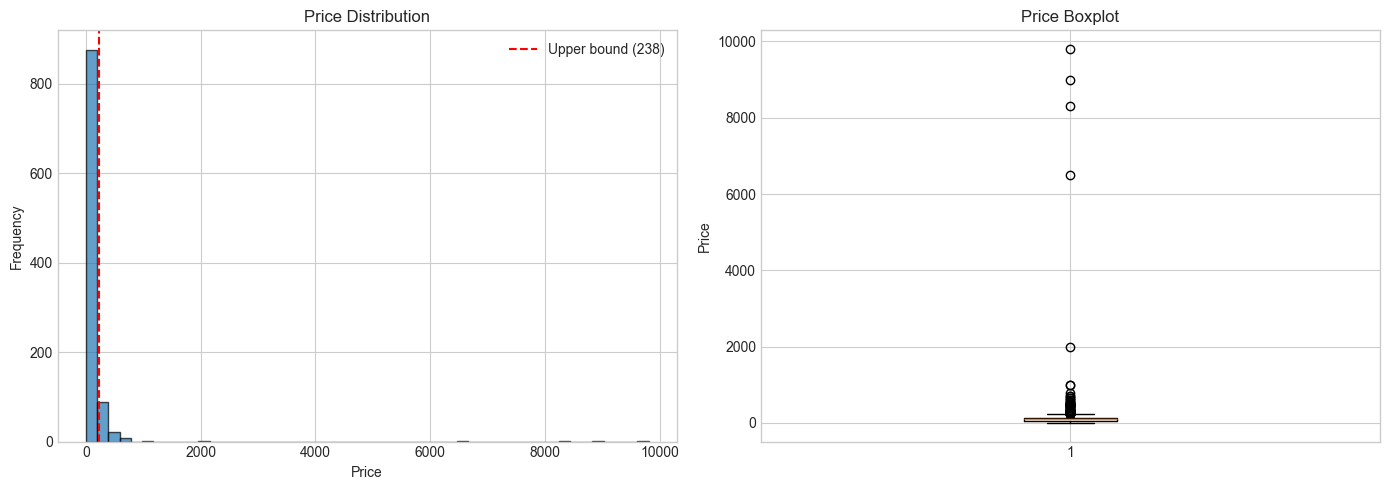

In [56]:
# Look for suspicious data points
print("Price Distribution:")
print(train_clean['price'].describe())

# Identify outliers
Q1 = train_clean['price'].quantile(0.25)
Q3 = train_clean['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (train_clean['price'] < lower_bound) | (train_clean['price'] > upper_bound)
n_outliers = outliers_mask.sum()
print(f"\nNumber of price outliers (IQR method): {n_outliers}")
print(f"Outlier prices range: below {lower_bound:.2f} or above {upper_bound:.2f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_clean['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound ({upper_bound:.0f})')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')
axes[0].legend()

axes[1].boxplot(train_clean['price'])
axes[1].set_ylabel('Price')
axes[1].set_title('Price Boxplot')
plt.tight_layout()
plt.show()

## Part 2: Model Training with and without Outliers

In [57]:
# Create two versions: with and without outliers
train_with_outliers = train_clean.copy()
train_no_outliers = train_clean[~outliers_mask].copy()

print(f"Training with outliers: {len(train_with_outliers)} samples")
print(f"Training without outliers: {len(train_no_outliers)} samples")

# Ensure consistent columns across all sets
common_cols = list(set(train_clean.columns) & set(opt_clean.columns) & set(test_clean.columns))
target_col = 'price'
feature_cols = [c for c in common_cols if c != target_col]

print(f"\nNumber of features: {len(feature_cols)}")

Training with outliers: 1000 samples
Training without outliers: 917 samples

Number of features: 28


In [58]:
# Prepare data
X_train_out = train_with_outliers[feature_cols]
y_train_out = train_with_outliers[target_col]

X_train_no = train_no_outliers[feature_cols]
y_train_no = train_no_outliers[target_col]

X_opt = opt_clean[feature_cols]
y_opt = opt_clean[target_col]

X_test = test_clean[feature_cols]
y_test = test_clean[target_col]

# Scale features
scaler = StandardScaler()

# With outliers
X_train_out_scaled = scaler.fit_transform(X_train_out)
X_opt_scaled_out = scaler.transform(X_opt)
X_test_scaled_out = scaler.transform(X_test)

# Without outliers (refit scaler)
scaler_no = StandardScaler()
X_train_no_scaled = scaler_no.fit_transform(X_train_no)
X_opt_scaled_no = scaler_no.transform(X_opt)
X_test_scaled_no = scaler_no.transform(X_test)

In [59]:
# Function to train and evaluate models
def train_evaluate_models(X_train, y_train, X_opt, y_opt, X_test, y_test, label):
    """Train OLS and LASSO, optimize on opt set, evaluate on test set."""
    results = {}
    
    # OLS
    ols = LinearRegression()
    ols.fit(X_train, y_train)
    ols_opt_mse = mean_squared_error(y_opt, ols.predict(X_opt))
    ols_test_mse = mean_squared_error(y_test, ols.predict(X_test))
    results['OLS'] = {'opt_mse': ols_opt_mse, 'test_mse': ols_test_mse, 'model': ols}
    
    # LASSO with CV on training data
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_opt_mse = mean_squared_error(y_opt, lasso.predict(X_opt))
    lasso_test_mse = mean_squared_error(y_test, lasso.predict(X_test))
    results['LASSO'] = {'opt_mse': lasso_opt_mse, 'test_mse': lasso_test_mse, 
                        'model': lasso, 'alpha': lasso.alpha_}
    
    print(f"\n{label}:")
    print(f"  OLS - Opt MSE: {ols_opt_mse:.2f}, Test MSE: {ols_test_mse:.2f}")
    print(f"  LASSO (α={lasso.alpha_:.4f}) - Opt MSE: {lasso_opt_mse:.2f}, Test MSE: {lasso_test_mse:.2f}")
    
    return results

# Train models
results_with = train_evaluate_models(
    X_train_out_scaled, y_train_out, X_opt_scaled_out, y_opt, 
    X_test_scaled_out, y_test, "WITH Outliers"
)

results_without = train_evaluate_models(
    X_train_no_scaled, y_train_no, X_opt_scaled_no, y_opt,
    X_test_scaled_no, y_test, "WITHOUT Outliers"
)


WITH Outliers:
  OLS - Opt MSE: 59090.95, Test MSE: 51262.71
  LASSO (α=52.3354) - Opt MSE: 56284.85, Test MSE: 35594.90

WITHOUT Outliers:
  OLS - Opt MSE: 53800.31, Test MSE: 39520.29
  LASSO (α=0.2840) - Opt MSE: 53694.09, Test MSE: 34743.21


## Part 3: Model Comparison

In [60]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['OLS (with outliers)', 'LASSO (with outliers)', 
              'OLS (no outliers)', 'LASSO (no outliers)'],
    'Opt MSE': [results_with['OLS']['opt_mse'], results_with['LASSO']['opt_mse'],
               results_without['OLS']['opt_mse'], results_without['LASSO']['opt_mse']],
    'Test MSE': [results_with['OLS']['test_mse'], results_with['LASSO']['test_mse'],
                results_without['OLS']['test_mse'], results_without['LASSO']['test_mse']]
})

comparison['Opt RMSE'] = np.sqrt(comparison['Opt MSE'])
comparison['Test RMSE'] = np.sqrt(comparison['Test MSE'])

print("\nModel Comparison:")
print("="*70)
print(comparison.to_string(index=False))

# Best model
best_idx = comparison['Test MSE'].idxmin()
print(f"\nBest Model: {comparison.loc[best_idx, 'Model']}")
print(f"Test RMSE: {comparison.loc[best_idx, 'Test RMSE']:.2f}")


Model Comparison:
                Model      Opt MSE     Test MSE   Opt RMSE  Test RMSE
  OLS (with outliers) 59090.953234 51262.713124 243.086308 226.412705
LASSO (with outliers) 56284.849056 35594.899452 237.244281 188.666106
    OLS (no outliers) 53800.313218 39520.286177 231.948945 198.797098
  LASSO (no outliers) 53694.088787 34743.208701 231.719850 186.395302

Best Model: LASSO (no outliers)
Test RMSE: 186.40


In [61]:
print("\nConclusions:")
print("="*70)
print("""
1. Best Model: The model with lowest test MSE is preferred.

2. Outlier Removal: Comparing with/without outliers shows whether extreme
   prices hurt or help prediction. If removing outliers improves test error,
   it suggests those points were detrimental (noise or errors).

3. Optimization vs Test Error: If opt and test errors are similar, the
   optimization set provides good estimates. Large discrepancies suggest
   overfitting to the optimization set.

4. LASSO vs OLS: LASSO may perform better if there are irrelevant features,
   as it performs automatic feature selection through L1 regularization.
""")


Conclusions:

1. Best Model: The model with lowest test MSE is preferred.

2. Outlier Removal: Comparing with/without outliers shows whether extreme
   prices hurt or help prediction. If removing outliers improves test error,
   it suggests those points were detrimental (noise or errors).

3. Optimization vs Test Error: If opt and test errors are similar, the
   optimization set provides good estimates. Large discrepancies suggest
   overfitting to the optimization set.

4. LASSO vs OLS: LASSO may perform better if there are irrelevant features,
   as it performs automatic feature selection through L1 regularization.



---
# Question 8: Theory - LASSO, Ridge and Variable Selection

Consider the linear regression model: $Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$

## Part 1: LASSO Coefficients Become Zero

**Claim:** For any dataset $(X_1, Y_1), \ldots, (X_n, Y_n)$, there exists some finite $\Lambda$ such that for all $\lambda > \Lambda$, the LASSO coefficients are exactly 0.

**Proof:**

The LASSO objective function is:
$$L(\beta_0, \beta_1) = \sum_{i=1}^n (Y_i - \beta_0 - \beta_1 X_i)^2 + \lambda(|\beta_0| + |\beta_1|)$$

The subdifferential conditions for optimality are:
$$-2\sum_{i=1}^n (Y_i - \beta_0 - \beta_1 X_i) + \lambda \cdot \text{sign}(\beta_0) \ni 0$$
$$-2\sum_{i=1}^n X_i(Y_i - \beta_0 - \beta_1 X_i) + \lambda \cdot \text{sign}(\beta_1) \ni 0$$

At $\beta_0 = \beta_1 = 0$, the subgradient conditions become:
$$-2\sum_{i=1}^n Y_i \in [-\lambda, \lambda]$$
$$-2\sum_{i=1}^n X_i Y_i \in [-\lambda, \lambda]$$

These conditions are satisfied when:
$$\lambda \geq \max\left(2\left|\sum_{i=1}^n Y_i\right|, 2\left|\sum_{i=1}^n X_i Y_i\right|\right) = \Lambda$$

Therefore, for any $\lambda > \Lambda$, the LASSO solution is $\hat{\beta}_0 = \hat{\beta}_1 = 0$. $\blacksquare$

In [62]:
# Numerical demonstration for Part 1
np.random.seed(42)
n_demo = 20
X_demo = np.random.randn(n_demo)
Y_demo = 2 + 3*X_demo + np.random.randn(n_demo)*0.5

# Compute theoretical Lambda
Lambda_theoretical = max(2*abs(np.sum(Y_demo)), 2*abs(np.sum(X_demo * Y_demo)))
print(f"Theoretical Λ: {Lambda_theoretical:.2f}")

# Test LASSO at various lambda values
lambdas = [0.01, 1, 10, Lambda_theoretical, Lambda_theoretical*1.5, Lambda_theoretical*2]

print("\nLASSO Coefficients at Various λ:")
print("-"*50)

X_demo_2d = X_demo.reshape(-1, 1)
for lam in lambdas:
    # sklearn uses alpha = lambda / (2*n)
    lasso = Lasso(alpha=lam/(2*n_demo), fit_intercept=True, max_iter=10000)
    lasso.fit(X_demo_2d, Y_demo)
    print(f"λ={lam:8.2f}: β₀={lasso.intercept_:8.4f}, β₁={lasso.coef_[0]:8.4f}")

Theoretical Λ: 93.02

LASSO Coefficients at Various λ:
--------------------------------------------------
λ=    0.01: β₀=  1.8534, β₁=  2.9204
λ=    1.00: β₀=  1.8485, β₁=  2.8921
λ=   10.00: β₀=  1.8045, β₁=  2.6352
λ=   93.02: β₀=  1.3985, β₁=  0.2647
λ=  139.53: β₀=  1.3531, β₁=  0.0000
λ=  186.04: β₀=  1.3531, β₁=  0.0000


## Part 2: Ridge Coefficients Never Exactly Zero

**Claim:** There exists a dataset such that for any finite $\lambda$, Ridge regression coefficients are not all exactly 0.

**Proof:**

The Ridge objective is:
$$L(\beta_0, \beta_1) = \sum_{i=1}^n (Y_i - \beta_0 - \beta_1 X_i)^2 + \lambda(\beta_0^2 + \beta_1^2)$$

Taking derivatives and setting to zero:
$$\frac{\partial L}{\partial \beta_0} = -2\sum_{i=1}^n (Y_i - \beta_0 - \beta_1 X_i) + 2\lambda\beta_0 = 0$$
$$\frac{\partial L}{\partial \beta_1} = -2\sum_{i=1}^n X_i(Y_i - \beta_0 - \beta_1 X_i) + 2\lambda\beta_1 = 0$$

For both to equal 0 at $\beta_0 = \beta_1 = 0$:
$$\sum_{i=1}^n Y_i = 0 \quad \text{and} \quad \sum_{i=1}^n X_i Y_i = 0$$

**Counterexample:** Consider the dataset where $X = (1, 2, 3, 4, 5)$ and $Y = (1, 2, 3, 4, 5)$.

Then $\sum Y_i = 15 \neq 0$ and $\sum X_i Y_i = 55 \neq 0$.

For this data, the Ridge solution with any finite $\lambda$ satisfies:
$$(n + \lambda)\beta_0 + (\sum X_i)\beta_1 = \sum Y_i$$
$$(\sum X_i)\beta_0 + (\sum X_i^2 + \lambda)\beta_1 = \sum X_i Y_i$$

Since the right-hand sides are non-zero, and the coefficient matrix is positive definite, the solution cannot be $(0, 0)$ for any finite $\lambda$. $\blacksquare$

In [63]:
# Numerical demonstration for Part 2
X_counter = np.array([1, 2, 3, 4, 5], dtype=float)
Y_counter = np.array([1, 2, 3, 4, 5], dtype=float)

print(f"Counterexample Dataset:")
print(f"X = {X_counter}")
print(f"Y = {Y_counter}")
print(f"Sum(Y) = {np.sum(Y_counter)} ≠ 0")
print(f"Sum(XY) = {np.sum(X_counter * Y_counter)} ≠ 0")

print("\nRidge Coefficients at Various λ:")
print("-"*50)

X_counter_2d = X_counter.reshape(-1, 1)
lambdas_ridge = [0.01, 1, 10, 100, 1000, 10000, 100000]

for lam in lambdas_ridge:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X_counter_2d, Y_counter)
    print(f"λ={lam:8.0f}: β₀={ridge.intercept_:12.8f}, β₁={ridge.coef_[0]:12.8f}")

print("\nObservation: As λ → ∞, coefficients approach 0 but never reach exactly 0.")

Counterexample Dataset:
X = [1. 2. 3. 4. 5.]
Y = [1. 2. 3. 4. 5.]
Sum(Y) = 15.0 ≠ 0
Sum(XY) = 55.0 ≠ 0

Ridge Coefficients at Various λ:
--------------------------------------------------
λ=       0: β₀=  0.00299700, β₁=  0.99900100
λ=       1: β₀=  0.27272727, β₁=  0.90909091
λ=      10: β₀=  1.50000000, β₁=  0.50000000
λ=     100: β₀=  2.72727273, β₁=  0.09090909
λ=    1000: β₀=  2.97029703, β₁=  0.00990099
λ=   10000: β₀=  2.99700300, β₁=  0.00099900
λ=  100000: β₀=  2.99970003, β₁=  0.00009999

Observation: As λ → ∞, coefficients approach 0 but never reach exactly 0.


---
## Summary

This homework covered:

1. **Cross-validation for KNN classification** on MNIST data
2. **Multiple regression methods** (OLS, Ridge, LASSO, stepwise) for wine quality prediction
3. **LOOCV for model selection** with polynomial regression
4. **Classification and ROC analysis** for GWAS disease screening
5. **Bayesian hierarchical modeling** for school rankings with shrinkage
6. **Bias-variance tradeoff** analysis via simulation
7. **Real-world regression workflow** with data cleaning and outlier handling
8. **Theoretical properties** of LASSO vs Ridge regularization

Key themes: Cross-validation, regularization, model selection, and the bias-variance tradeoff.